## Example 02 - Energy Use

**Example description:** Example of estimating energy use on a project by keeping track of energy useage for each step of the production cycle.

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Define work method:**](#1.-Define-work-method)<br>
   * [**1.1 Sites:**](#1.1-Define-the-project-sites)<br>
   * [**1.2 Equipment:**](#1.2-Define-the-project-equipment)<br>
   * [**1.3 Activities:**](#1.3-Define-the-activity)<br>
* [**2. Run the simulation:**](#2.-Run-the-simulation)<br>
* [**3. Post processing:**](#3.-Postprocessing)<br>

## 0. Import required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialization of the simulation
import openclsim.savesim as savesim

In [2]:
# Create simulation environment
simulation_start = datetime.datetime.now()

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())

## 1. Define work method

### 1.1 Define the project sites
You can specify a project site object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions
    core.HasSpill - enables tracking of spill
    core.HasSpillCondition - enable imposition of spill limits
    core.HasSoil - enables book keeping of soil layers and soil information

#### First create objects with the desired properties

In [3]:
# The generic site class
Site = type('Site', (core.Identifiable, # Give it a name
                     core.Log,          # Allow logging of all discrete events
                     core.Locatable,    # Add coordinates to extract distance information and visualize
                     core.HasContainer, # Add information on the material available at the site
                     core.HasResource), # Add information on serving equipment
            {})                         # The dictionary is empty because the site type is generic

#### Next specify the properties for sites you wish to create

In [4]:
# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {"env": my_env,                                # The simpy environment defined in the first cel
                  "name": "Winlocatie",                         # The name of the site
                  "ID": "6dbbbdf4-4589-11e9-a501-b469212bff5b", # For logging purposes
                  "geometry": location_from_site,               # The coordinates of the project site
                  "capacity": 500_000,                          # The capacity of the site
                  "level": 500_000}                             # The actual volume of the site


# Information on the dumping site - the "to site" - the "dump locatie"
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)     # lon, lat

data_to_site = {"env": my_env,                                # The simpy environment defined in the first cel
                "name": "Dumplocatie",                        # The name of the site
                "ID": "6dbbbdf5-4589-11e9-82b2-b469212bff5b", # For logging purposes
                "geometry": location_to_site,                 # The coordinates of the project site
                "capacity": 500_000,                          # The capacity of the site
                "level": 0}                                   # The actual volume of the site (empty of course)

#### Finally create specific instances of the predefined objects with the specified properties

In [5]:
# The two objects used for the simulation
from_site = Site(**data_from_site)
to_site   = Site(**data_to_site)

sites = [from_site, to_site]

### 1.2 Define the project equipment
You can specify a vessel object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.ContainerDependentMovable - s moving container, so capacity and location
    core.Processor - allows for loading and unloading
    core.HasResource - adds information on serving equipment
    core.HasDepthRestriction - adds information on depth restriction 
    core.HasSoil - adds soil object, because it moves soil
    core.HasPlume - initializes spill terms

#### First create objects with the desired properties

In [6]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.EnergyUse,                 # Add information on energy use
                                    core.HasCosts,                  # Add information on costs
                                    core.LoadingFunction,           # Add a loading function
                                    core.UnloadingFunction,         # Add an unloading function
                                   ),
                                   {})

#### Next specify the properties for vessel(s) you wish to create

In [7]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

In [8]:
# Energy use depends on vessel characteristics
def compute_energy_use_loading(variable_1, variable_2):
    # x could be the loaded volume, y could be the production rate
    # so x / y would be a unit of time
    return lambda x: x * (variable_1 * variable_2)

def compute_energy_use_unloading(variable_1, variable_2):
    # x could be the loaded volume, y could be the production rate
    # so x / y would be a unit of time
    return lambda x: x * (variable_1 * variable_2)

def compute_energy_use_sailing(variable_1, variable_2):
    # x could be the distance, y could be the sailing speed
    # so x / y would be a unit of time
    return lambda x, y, z: x / y * (variable_1 * variable_2)

In [9]:
# TSHD variables
data_hopper = {"env": my_env,                                                    # The simpy environment 
               "name": "Hopper 01",                                              # Name
               "ID": "6dbbbdf6-4589-11e9-95a2-b469212bff5b",                     # For logging purposes
               "geometry": location_from_site,                                   # It starts at the "from site"
               "loading_rate": 1,                                                # Loading rate
               "unloading_rate": 1,                                              # Unloading rate
               "capacity": 5_000,                                                # Capacity of the hopper
               "compute_v": compute_v_provider(5, 4.5),                          # Variable speed 
               "energy_use_loading": compute_energy_use_loading(5_000, 1.0),     # Variable energy use
               "energy_use_sailing": compute_energy_use_sailing(5_000, 0.5),     # Variable energy use
               "energy_use_unloading": compute_energy_use_unloading(5_000, 1.0), # Variable energy use
               "weekrate": 700_000}

In [10]:
# The simulation object
hopper = TransportProcessingResource(**data_hopper)

### 1.3 Define the activity

In [11]:
# Create activity
activity = model.Activity(env = my_env,           # The simpy environment defined in the first cel
                          name = "Soil movement", # We are moving soil
                          ID = "6dbbbdf7-4589-11e9-bf3b-b469212bff5b", # For logging purposes
                          origin = from_site,     # We originate from the from_site
                          destination = to_site,  # And therefore travel to the to_site
                          loader = hopper,        # The benefit of a TSHD, all steps can be done
                          mover = hopper,         # The benefit of a TSHD, all steps can be done
                          unloader = hopper,      # The benefit of a TSHD, all steps can be done
                          start_event = None,     # We can start right away
                          stop_event = None)      # We stop once there is nothing more to move

### 2. Run the simulation

In [12]:
my_env.run()

print("")
print("*** Installation of dike finished in {}".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))
print("*** Installation cost {:,.2f}€.".format(int(hopper.cost)))


*** Installation of dike finished in 16 days, 3:49:55
*** Installation cost 1,615,967.00€.


### 3. Postprocessing

#### Vessel planning

In [13]:
vessels = [hopper]

activities = ['loading', 'unloading', 'sailing filled', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

#### Some results

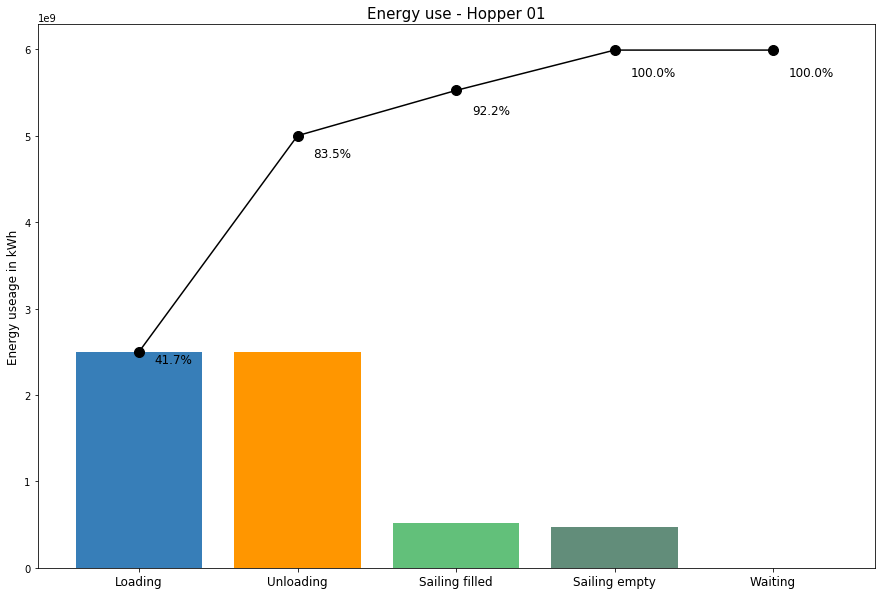

In [14]:
plot.energy_use(hopper)

#### KML visualisation

In [15]:
plot.vessel_kml(my_env, vessels, stepsize = 3600)
plot.site_kml(my_env, sites, stepsize = 3600)

In [16]:
# open the file
if platform.system():
    !start ./vessel_movements.kml
    !start ./site_development.kml
else:
    !start explorer ./vessel_movements.kml
    !start explorer ./site_development.kml

### 4. Save all logs

In [17]:
del hopper.log["Geometry - x"]
del hopper.log["Geometry - y"]
del hopper.log["timestamps_t"]
del hopper.log["timestamps_x"]
del hopper.log["timestamps_y"]

In [18]:
sites = [from_site, to_site]
equipment = [hopper]
activities = [activity]

save = savesim.LogSaver(sites, equipment, activities, 
                        simulation_id = '6f1aed5a-458f-11e9-861a-b469212bff5b', simulation_name = "Example 02",
                        location = "Simulation Results", overwrite = True)

save.save_all_logs()

In [19]:
save.unique_activities

,ActivityID,ActivityName
0,6dbbbdf7-4589-11e9-bf3b-b469212bff5b,Soil movement
